In [2]:
import pickle as pkl
import sys
sys.path.append('/Users/cosinga/code/hcolor/fig_md_analysis/')
sys.path.append('/Users/cosinga/code/figrid/')
import pk_plot_library as pplib
import numpy as np
import matplotlib.pyplot as plt

DRAFTPATH = '/Users/cosinga/overleaf/hicolor_draft_two/figures/'
SAVEPATH = '/Users/cosinga/code/hcolor/fig_md_analysis/rvb/'
WEBPATH = '/Users/cosinga/code/calvinosinga.github.io/hicolor/sup_analysis/'
pplib.imports()

def fill_mean(ax, data, kwargs):
    x = data[0]
    y = np.mean(np.array([data[1], data[2]]), axis = 0)
    kwargs['alpha'] = 1
    ax.plot(x, y, **kwargs)
    return
def renorm(dc):
    data = dc.getData()
    data[1] = data[0]**2 * data[1]
    dc.setData(data)
    return dc
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
def kaiser(z, bias):
    D = cosmo.growthFactor(z, derivative = 0)
    dDdz = cosmo.growthFactor(z, derivative = 1)
    f = -dDdz * (z + 1) / D
    beta = f / bias
    return (1 + 2/3 * beta + 1/5 * beta**2)
def Plin(k, z):
    return cosmo.matterPowerSpectrum(k, z)


ds = pkl.load(open('/Users/cosinga/code/hcolor/fig_md_analysis/1-30_pkdatasort.pkl', 'rb'))

ds.tickArgs(direction = 'in', right = True, top = True, labelsize = 14)
ds.legendArgs(frameon = False, loc = 'upper right', fontsize = 14, slc = (-1, -1))

ds.axisLabelArgs('both', fontsize = 16)
ds.rowLabelArgs(pos = [0.05, 0.05], fontsize = 16, ha = 'left', va = 'bottom')
ds.colLabelArgs(pos = [0.5, 0.95], fontsize = 16, ha = 'center' , va = 'top')
ds.axisArgs(xscale = 'log', yscale = 'log', xlim = [0.11866199299595938, 20])

ds.setOrder('space', ['real', 'redshift', 'rsd'])

ds.displayAs('space', ['real', 'redshift', 'rsd'], ['Real Space', 'Redshift Space', 'Redshift Space\nDistortions'])
ds.displayAs('snapshot', [99, 67, 50], ['z = 0.0', 'z = 0.5', 'z = 1.0'])
# ds.displayAs('color', ['blue', 'red', 'resolved'], 
#              ['HI $\\times$ Blue Bias', 'HI $\\times$ Red Bias', 'HI $\\times$ Galaxy Bias'])
ds.displayAs('HI_fieldname', ['hisubhalo', 'vn', 'hiptl'], ['Galaxy Centers', 'All Particles', 'Particles in Galaxies'])

ds.setColors('HI_fieldname', ['firebrick', 'saddlebrown', 'sandybrown'], ['vn', 'hiptl', 'hisubhalo'])
ds.setColors('color', ['red', 'blue', 'gray'], ['red', 'blue', 'resolved'])

ds.setXLabel(pplib.wnum())

In [3]:
def get_pk(fn, gr, **others):
    def sub_get(ip, subtype):
        ip['subtype'] = subtype
        dclist = ds.getMatching(ip)
        if len(dclist) > 1:
            print("too many DCs found")
            for dc in dclist:
                print(dc.attrs)
        return dclist[0].getData()
    ip = {
        'path':'vel',
        'fieldname':fn,
        'space':'real',
        'grid_resolution':gr
    }
    ip.update(others)
    dd = sub_get(ip, 'delta_delta')
    tt = sub_get(ip, 'theta_theta')
    td = sub_get(ip, 'theta_delta')
    ip['space'] = 'redshift'
    dd_s = sub_get(ip, 'delta_delta')
    return dd, td, tt, dd_s


In [4]:
pdd, ptd, ptt, prss = get_pk('ptl', 200, ptl_species = 'ptl')
# pkl.dump(ptd, open('../theta_delta_demo_50.pkl', 'wb'), pkl.HIGHEST_PROTOCOL)
# pkl.dump(ptt, open('../theta_theta_demo_50.pkl', 'wb'), pkl.HIGHEST_PROTOCOL)
# pkl.dump(pdd, open('../delta_delta_demo_50.pkl', 'wb'), pkl.HIGHEST_PROTOCOL)

# Confirming Expression for Redshift-Space Monopole

<a href="https://wwwmpa.mpa-garching.mpg.de/~komatsu/lecturenotes/Shun_Saito_on_RSD.pdf">Link to Reference</a>

Equation 21: Expanding the anisotropic power spectrum with Legendre Polynomials

$P^s(k, \mu) = \sum_{\ell} P_{\ell}^s(k) \mathcal{L}_{\ell}(\mu)$

I believe that $P_{\ell}$ is in redshift space, although it is not explicitly notated in the reference.

Legendre Polynomials are orthogonal, giving

$\int_{-1}^{1} \mathcal{L}_{\ell}(\mu) \mathcal{L}_{\ell'}(\mu) \, d\mu = \frac{2}{2\ell + 1} \delta_{\ell\ell'}$

$\int_{-1}^{1} P^s(k, \mu) \mathcal{L}_{\ell'}(\mu) \, d\mu = \sum_{\ell} P_{\ell}(k) \int_{-1}^{1} \mathcal{L}_{\ell}(\mu) \mathcal{L}_{\ell'}(\mu) \, d\mu$

$\int_{-1}^{1} P^s(k, \mu) \mathcal{L}_{\ell'}(\mu) \, d\mu = P_{\ell'}(k)$

We then arrive at the following expression, which tells us how to get from the anisotropic power spectrum to P(k):

$P_{\ell'}^s(k) = \frac{2\ell' + 1}{2} \int_{-1}^{1} P^s(k, \mu) \mathcal{L}_{\ell'}(\mu) \, d\mu$

Only $l = 0, 2, 4$ have non-vanishing terms in the Kaiser formula. Here are are these terms: $\mathcal{L}_0 (x)= 1$, $\mathcal{L}_2 (x)= 1/2 (3x^2-1)$, $\mathcal{L}_4 (x) = 1/8(35x^4 - 30x^2 + 3)$. For my purposes, I have only used the monopole.

$P_0^s (k) = 1/2 \int_{-1}^1 d\mu P^s (k, \mu)$

Equation 30: expressing the kaiser effect, including the linear and non-linear terms.

$P^s_{\rm{L}} (k, \mu) = (1 + f \mu^2)^2 P^r_{\delta \delta}(k)$

$P^s_{\rm{NL}} (k, \mu) = P^r_{\delta \delta}(k) + 2f\mu^2 P_{\delta \theta} (k) + f^2 \mu^4 P_{\theta \theta} (k)$

Combining the expression that gives $P(k)$ from $P(k, \mu)$ and the above equation, we can get the general equation for redshift-space distortions for the monopole.

$P_0^s (k) = P^r_{\delta \delta}(k) + 2/3 f P_{\delta \theta} (k) + 1/5 f^2 P_{\theta \theta} (k)$

In other words, the anisotropic power spectrum has the same expression as the monopole of the isotropic power spectrum.

Check out papers describing velocity bias assumptions...



In [5]:
from colossus.cosmology import cosmology
cosmo = cosmology.setCosmology('planck15')
def growth_rate(z):
    D = cosmo.growthFactor(z, derivative = 0)
    dDdz = cosmo.growthFactor(z, derivative = 1)
    f = -dDdz * (z + 1) / D
    return f

Text(0.5, 0, 'k (cMpc/h)')

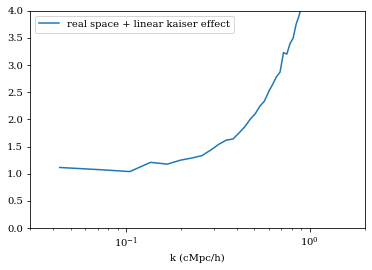

In [6]:
f = growth_rate(1)
pred = (1 + 2/3 * f + f**2 / 5) * pdd[1]
plt.plot(pdd[0], pred / prss[1], label = 'real space + linear kaiser effect')
plt.xscale('log')
plt.legend()
plt.xlim(0.03, 2)
plt.ylim(0, 4)
plt.xlabel('k (cMpc/h)')

In [7]:
print(f**2 / 5)

0.15253055630138218


Text(0.5, 1.0, '200$^3$ Grid, TNG 300, z = 1')

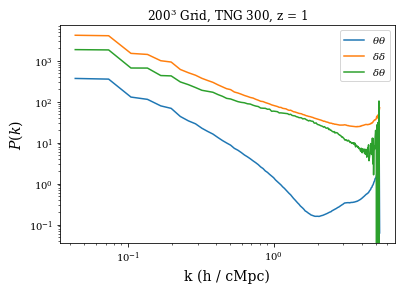

In [8]:
plt.plot(ptt[0], ptt[1] / 1e4 * f**2 / 5, label = r'$\theta \theta$')
plt.plot(pdd[0], pdd[1], label = r'$\delta \delta$')
plt.plot(ptd[0], ptd[1] / (1e2) * f * 2/3 , label = r'$\delta \theta$')
plt.ylabel(r"$P (k)$", fontsize = 14)
plt.xlabel(r"k (h / cMpc)", fontsize = 14)
plt.loglog()
plt.legend()
plt.title("200$^3$ Grid, TNG 300, z = 1")

[]

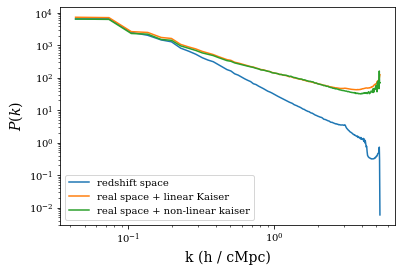

In [9]:
plt.plot(prss[0], prss[1], label = 'redshift space')
plt.plot(pdd[0], (1 + 2/3 * f + 1/5*f) * pdd[1], label = 'real space + linear Kaiser')
plt.plot(ptd[0], pdd[1] + ptd[1]/1e2 * 2/3 * f + 1/5 * f * ptt[1] / 1e4, label = 'real space + non-linear kaiser')
plt.ylabel(r"$P (k)$", fontsize = 14)
plt.xlabel(r"k (h / cMpc)", fontsize = 14)
plt.legend()
plt.loglog()

(0.03, 2)

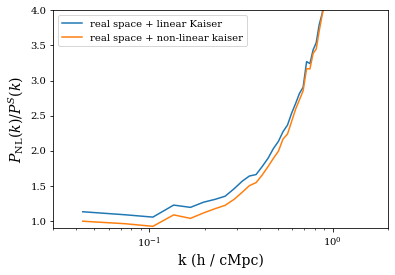

In [10]:
plt.plot(pdd[0], (1 + 2/3 * f + 1/5*f) * pdd[1] / prss[1], label = 'real space + linear Kaiser')
plt.plot(ptd[0], (pdd[1] + ptd[1] * 2/3 * f / 1e2 + 1/5 * f * ptt[1] / 1e4) / prss[1], label = 'real space + non-linear kaiser')
plt.ylabel(r"$P_{\mathrm{NL}} (k) / P^{S} (k)$", fontsize = 14)
plt.xlabel(r"k (h / cMpc)", fontsize = 14)
plt.legend()
plt.xscale('log')
plt.ylim(0.9, 4)
plt.xlim(0.03, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


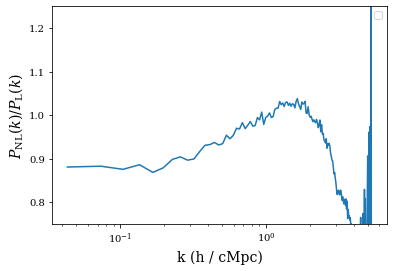

In [11]:
plt.plot(ptd[0], (pdd[1] + ptd[1] * 2/3 * f / 1e2 + 1/5 * f * ptt[1] / 1e4) / (1 + 2/3 * f + 1/5*f) / pdd[1])
plt.ylabel(r"$P_{\mathrm{NL}} (k) / P_{\mathrm{L}} (k)$", fontsize = 14)
plt.xlabel(r"k (h / cMpc)", fontsize = 14)
plt.legend()
plt.ylim(0.75, 1.25)
plt.xscale('log')

Text(0.5, 1.0, '200$^3$ Grid, TNG 300, z = 1')

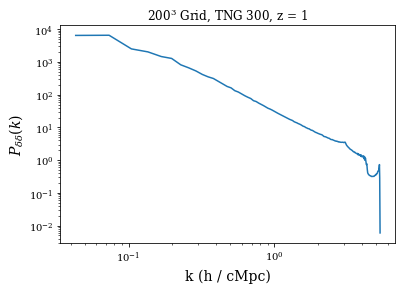

In [12]:
plt.plot(prss[0], prss[1])
plt.ylabel(r"$P_{\delta \delta} (k)$", fontsize = 14)
plt.xlabel(r"k (h / cMpc)", fontsize = 14)
plt.loglog()
plt.title("200$^3$ Grid, TNG 300, z = 1")

# velocity power spectrum grid resolution

In [13]:
print(ds.getAttrs())
print(ds.getAttrVals('ptl_species'))
print(ds.getAttrVals('subtype'))

['path', 'result_type', 'result_runtime', 'is_auto', 'box', 'simname', 'sim_resolution', 'num_part', 'grid_resolution', 'snapshot', 'redshift', 'axis', 'fieldname', 'is_hydrogen', 'is_atomic', 'is_molecular', 'is_particle', 'is_groupcat', 'is_matter', 'mas', 'space', 'compute_xi', 'compute_slice', 'color', 'gal_species', 'gal_res', 'color_cut', 'ptl_species', 'map', 'model', 'HI_fieldname', 'projection', 'HI_res', 'censat', 'type', 'subtype', 'empty_cells', 'post_process', 'numerator', 'denominator']
['no key found', 'dm', 'gas', 'ptl', 'stmass']
['no key found', 'delta_delta', 'theta_delta', 'theta_theta']


3
The row values for : ['no key found']
The column values for : ['no key found']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


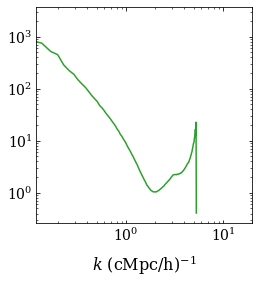

In [14]:
ip = {'path':'vel', 'fieldname':'ptl', 'type':'vel', 'ptl_species':'ptl', 'subtype':'theta_theta'}
print(len(ds.getMatching(ip)))
fg = ds.figrid('grid_resolution', '', '', ip)
fg.axisArgs(yscale = 'log', xscale = 'log')
def div(dc):
    data = dc.getData()
    data[1] /= 1e4
    dc.setData(data)
    return dc
fg.adjustData({}, div)
fg.plot()


# finding the FoG for both HI and matter

In [15]:
pdd, ptd, ptt, prss = get_pk('ptl', 200, ptl_species = 'ptl')
print(ptt)
hidd, hitd, hitt, hirss = get_pk('vn', 200)
print(hitt)

[array([0.04341288, 0.07355669, 0.10462391, 0.13578833, 0.16756584,
       0.19745789, 0.22813252, 0.25893781, 0.29001768, 0.32079145,
       0.35105526, 0.38184687, 0.41319019, 0.44374901, 0.47418487,
       0.50476246, 0.53540314, 0.56611858, 0.59691203, 0.62771574,
       0.65829307, 0.68875588, 0.71957735, 0.75017809, 0.78080856,
       0.81170301, 0.84253446, 0.8730562 , 0.90358717, 0.93405209,
       0.96482433, 0.99557938, 1.02631185, 1.05702913, 1.08765867,
       1.11835123, 1.14884952, 1.17946858, 1.21017392, 1.24072793,
       1.27138256, 1.30207677, 1.33288944, 1.36367301, 1.39432502,
       1.42481769, 1.45534139, 1.48604031, 1.51672153, 1.54739911,
       1.57814028, 1.60886255, 1.63959826, 1.67009774, 1.70072107,
       1.7314203 , 1.7619107 , 1.79256931, 1.82324283, 1.85397758,
       1.88465359, 1.91519033, 1.94598268, 1.97662109, 2.00727633,
       2.03795818, 2.06848812, 2.09923204, 2.12993101, 2.16048594,
       2.19104118, 2.22166544, 2.25250462, 2.28324109, 2.3138

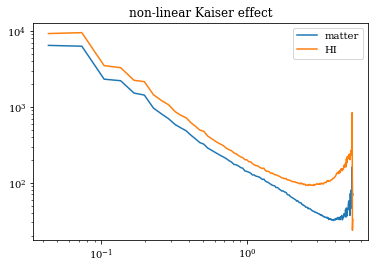

In [16]:
def calc_nlk(z, dd, td, tt):
    f = growth_rate(z)
    return (dd[1] + td[1] * 2/3 * f / 1e2 + 1/5 * f * tt[1] / 1e4)
mnlk = calc_nlk(1, pdd, ptd, ptt)
hinlk = calc_nlk(1, hidd, hitd, hitt)
plt.loglog(pdd[0], mnlk, label = 'matter')
plt.loglog(hidd[0], hinlk, label = 'HI')
plt.title('non-linear Kaiser effect')
plt.legend()

Text(0.5, 0, '$k$ (cMpc/h)$^{-1}$')

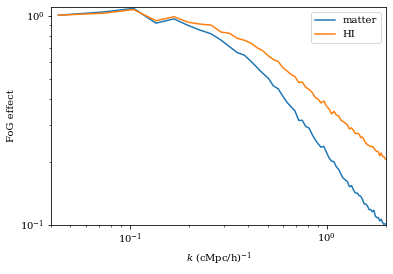

In [17]:
# trying to isolate FoG


pfog = prss[1] / mnlk
hifog = hirss[1] / hinlk
plt.loglog(prss[0], pfog, label = 'matter')
plt.loglog(hirss[0], hifog, label = 'HI')
plt.legend()
plt.xlim(.04, 2)
plt.ylim(0.1, 1.1)
plt.ylabel('FoG effect')
plt.xlabel(pplib.wnum())

In [30]:
from scipy.integrate import quad

def gauss(mu, k, sigma_p, f):
    return np.exp(- (1/2*mu*k*sigma_p*f)**2)

def lorentz(mu, k, sigma_p, f):
    return (1 + (1/2*mu*k*sigma_p*f)**2)**(-1)

def gint(k, sigma_p, z):
    f = growth_rate(z)
    fog = np.zeros_like(k)
    if isinstance(k, float):
        result, error = quad(gauss, -1, 1, args = (k, sigma_p, f))
        return result / 2
    for i in range(len(k)):
        result, error = quad(gauss, -1, 1, args = (k[i], sigma_p, f))
        fog[i] = result / 2
    return fog

def lint(k, sigma_p, z):
    f = growth_rate(z)
    fog = np.zeros_like(k)
    if isinstance(k, float):
        result, error = quad(lorentz, -1, 1, args = (k, sigma_p, f))
        return result / 2
    for i in range(len(k)):
        result, error = quad(lorentz, -1, 1, args = (k[i], sigma_p, f))
        fog[i] = result / 2
    
    return fog


In [31]:
hi_fog_mod = np.zeros((hifog.shape[0], 2))
m_fog_mod = np.zeros_like(hi_fog_mod)
GAU_IDX = 0
LTZ_IDX = 1
hi_sp = 1.93 # taken from CHIME
m_sp = 4 # random guess
for i in range(len(hirss[0])):
    hi_fog_mod[i, GAU_IDX] = gint(hirss[0][i], hi_sp, 1)
    m_fog_mod[i, GAU_IDX] = gint(hirss[0][i], m_sp, 1)
    hi_fog_mod[i, LTZ_IDX] = lint(hirss[0][i], hi_sp, 1)
    m_fog_mod[i, LTZ_IDX] = lint(hirss[0][i], m_sp, 1)


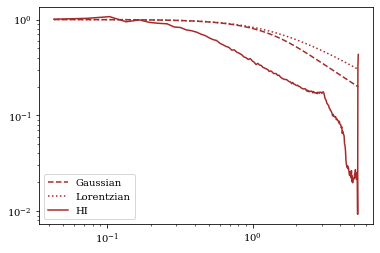

In [32]:
plt.loglog(hirss[0], hi_fog_mod[:, GAU_IDX], linestyle = 'dashed', color = 'brown', label = 'Gaussian')
plt.loglog(hirss[0], hi_fog_mod[:, LTZ_IDX], linestyle = 'dotted', color = 'brown', label = 'Lorentzian')
plt.loglog(hirss[0], hifog, color = 'brown', label = 'HI')
plt.legend()

# reporting sigma_p values

In [33]:
from scipy.optimize import curve_fit
fit_mask = (hirss[0] < 2)
kcut = hirss[0][fit_mask] # to avoid fitting to noisy values
hifog_cut = hifog[fit_mask]

def fit_gauss(k, sigma_p):
    val = gint(k, sigma_p, 1)
    return val
def fit_lorentz(k, sigma_p):
    val = lint(k, sigma_p, 1)
    return val

gparams, gcov = curve_fit(fit_gauss, kcut, hifog_cut, bounds = (0.5, 100), p0 = 1.5)
lparams, lcov = curve_fit(fit_lorentz, kcut, hifog_cut, bounds = (0.5, 100), p0 = 1.5)


In [34]:
print(gparams[0], lparams[0])
print(gcov, lcov)

5.535024653329092 7.532880745908111
[[0.00205256]] [[0.01111724]]


In [35]:
hi_fog_fit = np.zeros((kcut.shape[0], 2))
m_fog_fit = np.zeros_like(hi_fog_fit)
for i in range(len(kcut)):
    hi_fog_fit[i, GAU_IDX] = gint(kcut[i], hi_sp, 1)
    m_fog_fit[i, GAU_IDX] = gint(kcut[i], m_sp, 1)
    hi_fog_fit[i, LTZ_IDX] = lint(kcut[i], hi_sp, 1)
    m_fog_fit[i, LTZ_IDX] = lint(kcut[i], m_sp, 1)

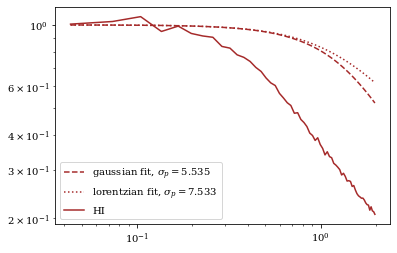

In [36]:
plt.loglog(kcut, hi_fog_fit[:, GAU_IDX], linestyle = 'dashed', color = 'brown', label = 'gaussian fit, $\\sigma_p = %.3f$'%gparams[0])
plt.loglog(kcut, hi_fog_fit[:, LTZ_IDX], linestyle = 'dotted', color = 'brown', label = 'lorentzian fit, $\\sigma_p = %.3f$'%lparams[0])
plt.loglog(kcut, hifog[fit_mask], color = 'brown', label = 'HI')
plt.legend()